In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from tree import Tree

np.seterr(all="ignore")
if not hasattr(np, 'alltrue'):
    np.alltrue = np.all

In [2]:
NUM_ISLANDS = 5
ISLAND_SIZE = 100
GENERATIONS = 1000
MAX_DEPTH = 5
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 250
MIGRATION_SIZE = 2
PRINT_INTERVAL = 200
TREE_ATTEMPTS = 10
TEST_TRAIN = 0.8

In [3]:
def plot_fitness_trend(fitness_history):
    """
    Plot the trend of best fitness over generations.

    Parameters:
        fitness_history (list): A list of best fitness values recorded over generations.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def plot_predictions(y_test, y_pred):
    """
    Plots a comparison between actual and predicted values with sorting.

    Parameters:
        y_test: The actual values from the test dataset.
        y_pred: The predicted values generated by the model.
    """

    sorted_indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_indices]
    y_pred_sorted = np.array(y_pred)[sorted_indices]

    plt.figure(figsize=(10, 5))

    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
class SymbolicRegressionGP:
    def __init__(self,
                 x_train,
                 y_train,
                 num_islands=NUM_ISLANDS,
                 island_size=ISLAND_SIZE,
                 generations=GENERATIONS, 
                 max_depth=MAX_DEPTH,
                 mutation_rate=MUTATION_RATE,
                 tournament_size=TOURNAMENT_SIZE,
                 migration_interval=MIGRATION_INTERVAL,
                 migration_size=MIGRATION_SIZE,
                 print_interval=PRINT_INTERVAL,
                 tree_attempts=TREE_ATTEMPTS):
        """
        Initialize the Symbolic Regression Genetic Programming (GP) model.

        Parameters:
            x_train, y_train: Training data arrays.
            num_islands: Number of islands (subpopulations).
            island_size: Number of trees per island.
            generations: Number of generations to run.
            max_depth: Maximum depth allowed for generated trees.
            mutation_rate: Probability that an offspring is mutated.
            tournament_size: Number of individuals in tournament selection.
            migration_interval: How often (in generations) migration occurs.
            migration_size: How many individuals migrate from each island.
            print_interval: Interval for printing progress.
            tree_attempts: Number of attempts to generate a valid tree.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.island_size = island_size
        self.generations = generations
        self.max_depth = max_depth
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.print_interval = print_interval
        self.tree_attempts = tree_attempts

        # List of islands; each island is a list of Tree objects.
        self.populations = []

    def initialize_population(self):
        """Initialize each island with random trees."""
        self.populations = []
        for i in range(self.num_islands):
            island = []        
            while len(island) < self.island_size:
                tree = Tree(max_depth=self.max_depth, x_train=self.x_train, y_train=self.y_train, tree_attempts=self.tree_attempts)
                tree.populate()
                if np.isfinite(tree.fitness):
                    island.append(tree)
            self.populations.append(island)

    def tournament_selection(self, population):
        """
        Select one individual from a population using rank-based tournament selection.

        Parameters:
            population: List of Tree objects representing the population.

        Returns:
            A single individual (tree) selected from the tournament.
        """

        tournament_size = min(self.tournament_size, len(population))
        participants = random.sample(population, tournament_size)
        
        # Sort participants so that the best individual (lowest fitness) is first.
        participants.sort(key=lambda tree: tree.fitness)
        
        # Compute rank-based weights.
        weights = [tournament_size - i for i in range(tournament_size)]
        
        # Use the weights to choose one candidate.
        chosen = random.choices(participants, weights=weights, k=1)[0]
        return chosen

    def migrate(self):
        """
        Migrate the best individuals from each island to the next island (in a ring).
        Here, for each island we select the best `migration_size` individuals and
        replace the worst individuals of the neighboring island if they are better.
        """
        for i in range(self.num_islands):
            source = self.populations[i]
            target_index = (i + 1) % self.num_islands  # next island (ring topology)
            target = self.populations[target_index]
            
            # Get the top individuals from the source island.
            migrants = sorted(source, key=lambda tree: tree.fitness)[:self.migration_size]
            # Sort the target island from worst to best.
            target_sorted = sorted(target, key=lambda tree: tree.fitness, reverse=True)
            
            for j in range(self.migration_size):
                # Replace if the migrant is better than the corresponding worst in target.
                if migrants[j].fitness < target_sorted[j].fitness:
                    index_to_replace = target.index(target_sorted[j])
                    target[index_to_replace] = migrants[j].clone_tree()
            self.populations[target_index] = target

    def run(self):
        """
        Run the genetic programming algorithm.

        Returns:
            best_tree: The best tree found during the run.
            best_fitness_history: List of the best fitness values over generations.
        """
        self.initialize_population()
        best_tree = None
        best_fitness = np.inf
        best_fitness_history = []

        for gen in tqdm(range(self.generations), desc="Generations"):
            # Evolve each island separately.
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                new_pop = []
                elite = min(current_pop, key=lambda tree: tree.fitness)
                new_pop.append(elite.clone_tree())
                while len(new_pop) < self.island_size:
                    if random.random() < self.mutation_rate:
                        parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        parent1 = self.tournament_selection(current_pop)
                        parent2 = self.tournament_selection(current_pop)
                        child1, child2 = parent1.recombine(parent2)
                        new_pop.append(child1)
                        new_pop.append(child2)
                self.populations[island_index] = np.concatenate((self.populations[island_index], new_pop))
                self.populations[island_index] = sorted(self.populations[island_index], key=lambda tree: tree.fitness)
                self.populations[island_index] = self.populations[island_index][:self.island_size]
                
            # Migration step.
            if (gen + 1) % self.migration_interval == 0:
                self.migrate()

            if (gen + 1) % self.print_interval == 0:
                print(f"Generation {gen + 1}:")
            # Update best overall solution.
            idx = 0
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                best_island_tree = min(current_pop, key=lambda tree: tree.fitness)
                if (gen + 1) % self.print_interval == 0:
                    print(f"    Island {idx + 1}; Best fitness: {best_island_tree.fitness:.6f}")
                    idx += 1
                if best_island_tree.fitness < best_fitness:
                    best_fitness = best_island_tree.fitness
                    best_tree = best_island_tree.clone_tree()
                    
            best_fitness_history.append(best_fitness)
            if (gen + 1) % self.print_interval == 0:
                print(f"    Best global fitness: {best_fitness:.6f}")
                print(f"    Best global formula: {best_tree}\n")
        return best_tree, best_fitness_history

In [6]:
def run_sym_reg_gp(problem_num):    
    """
    Run symbolic regression using Genetic Programming (GP) on a specified problem.
    This function loads a dataset corresponding to the given problem number, shuffles the data,
    splits it into training and testing sets, and then runs a symbolic regression GP algorithm.
    The best resulting formula is evaluated on both the training and testing sets, and the results
    are printed and plotted.
    
    Parameters:
        problem_num (int): The problem number corresponding to the dataset to be loaded.
    """
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_1 = problem['x']
    y_1 = problem['y']
    problem_len = len(y_1)

    # Shuffle the data
    permutation = np.random.permutation(problem_len)
    x_1 = x_1[:, permutation]
    y_1 = y_1[permutation]

    # Determine train-test split sizes
    train_size = int(TEST_TRAIN * problem_len)

    # Split data into training and testing sets
    x_train = x_1[:, :train_size]
    y_train = y_1[:train_size]
    x_test = x_1[:, train_size:]
    y_test = y_1[train_size:]

    # Instantiate and run the symbolic regression GP
    gp = SymbolicRegressionGP(x_train,
                              y_train,
                              num_islands=NUM_ISLANDS,
                              island_size=ISLAND_SIZE,
                              generations=GENERATIONS,
                              max_depth=MAX_DEPTH,
                              mutation_rate=MUTATION_RATE,
                              tournament_size=TOURNAMENT_SIZE,
                              migration_interval=MIGRATION_INTERVAL,
                              migration_size=MIGRATION_SIZE,
                              print_interval=PRINT_INTERVAL
                              )
    
    print(f"\n\nProblem {problem_num}\n")
    best_tree, best_fitness_history = gp.run()

    # Evaluate the best tree on the test set
    new_tree = best_tree.clone_tree()
    new_tree.x_train = x_test
    new_tree.y_train = y_test
    y_pred = new_tree.compute_fitness(True)

    # Print results
    print("Best global formula: ", best_tree)
    print("Best training fitness: ", best_tree.fitness)
    print("Best testing fitness: ", new_tree.fitness)

    # Plot the best tree and fitness trend
    best_tree.plot()
    plot_fitness_trend(best_fitness_history)
    plot_predictions(y_test, y_pred)

### Problem 0



Problem 0



Generations:  20%|█▉        | 199/1000 [00:11<00:46, 17.37it/s]

Generation 200:
    Island 1; Best fitness: 0.010664
    Island 2; Best fitness: 0.010664
    Island 3; Best fitness: 0.010664
    Island 4; Best fitness: 0.010664
    Island 5; Best fitness: 0.010664
    Best global fitness: 0.010664
    Best global formula: x[0]



Generations:  40%|████      | 401/1000 [00:23<00:37, 16.17it/s]

Generation 400:
    Island 1; Best fitness: 0.010664
    Island 2; Best fitness: 0.010664
    Island 3; Best fitness: 0.010664
    Island 4; Best fitness: 0.010664
    Island 5; Best fitness: 0.005518
    Best global fitness: 0.005518
    Best global formula: np.minimum(x[0], np.add(np.absolute(np.remainder(np.negative(x[1]), np.multiply(x[1], 1.7584125144807357))), np.add(x[0], np.multiply(x[1], 0.9226761499291958))))



Generations:  60%|██████    | 600/1000 [00:35<00:26, 15.22it/s]

Generation 600:
    Island 1; Best fitness: 0.005477
    Island 2; Best fitness: 0.010664
    Island 3; Best fitness: 0.010664
    Island 4; Best fitness: 0.010664
    Island 5; Best fitness: 0.001449
    Best global fitness: 0.001449
    Best global formula: np.minimum(np.add(0.03245046258076423, np.add(0.017900942110807616, np.add(0.017900942110807616, x[0]))), np.add(np.absolute(np.remainder(np.negative(x[1]), np.multiply(x[1], 1.7584125144807357))), np.add(x[0], np.multiply(x[1], np.tanh(1.7993323378214163)))))



Generations:  80%|████████  | 802/1000 [00:52<00:15, 12.55it/s]

Generation 800:
    Island 1; Best fitness: 0.000022
    Island 2; Best fitness: 0.005475
    Island 3; Best fitness: 0.005474
    Island 4; Best fitness: 0.005475
    Island 5; Best fitness: 0.000036
    Best global fitness: 0.000022
    Best global formula: np.minimum(np.add(np.tanh(np.tanh(np.tan(x[1]))), np.add(np.negative(x[1]), np.add(np.square(0.6528258878453492), x[0]))), np.add(np.negative(np.remainder(np.negative(x[1]), np.multiply(1.7584125144807357, x[1]))), np.add(x[0], np.multiply(x[1], np.tanh(1.7315647953262512)))))



Generations: 100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


Generation 1000:
    Island 1; Best fitness: 0.000022
    Island 2; Best fitness: 0.000022
    Island 3; Best fitness: 0.000022
    Island 4; Best fitness: 0.000022
    Island 5; Best fitness: 0.000022
    Best global fitness: 0.000022
    Best global formula: np.minimum(np.add(np.tanh(np.tanh(np.cosh(1.11997858020315))), np.add(np.negative(x[1]), np.add(np.square(0.6528258878453492), x[0]))), np.add(np.negative(np.remainder(np.negative(x[1]), np.multiply(1.7584125144807357, x[1]))), np.add(x[0], np.multiply(x[1], np.tanh(1.7319312973914491)))))

Best global formula:  np.minimum(np.add(np.tanh(np.tanh(np.cosh(1.11997858020315))), np.add(np.negative(x[1]), np.add(np.square(0.6528258878453492), x[0]))), np.add(np.negative(np.remainder(np.negative(x[1]), np.multiply(1.7584125144807357, x[1]))), np.add(x[0], np.multiply(x[1], np.tanh(1.7319312973914491)))))
Best training fitness:  2.161126467452189e-05
Best testing fitness:  2.2120341727990498e-05


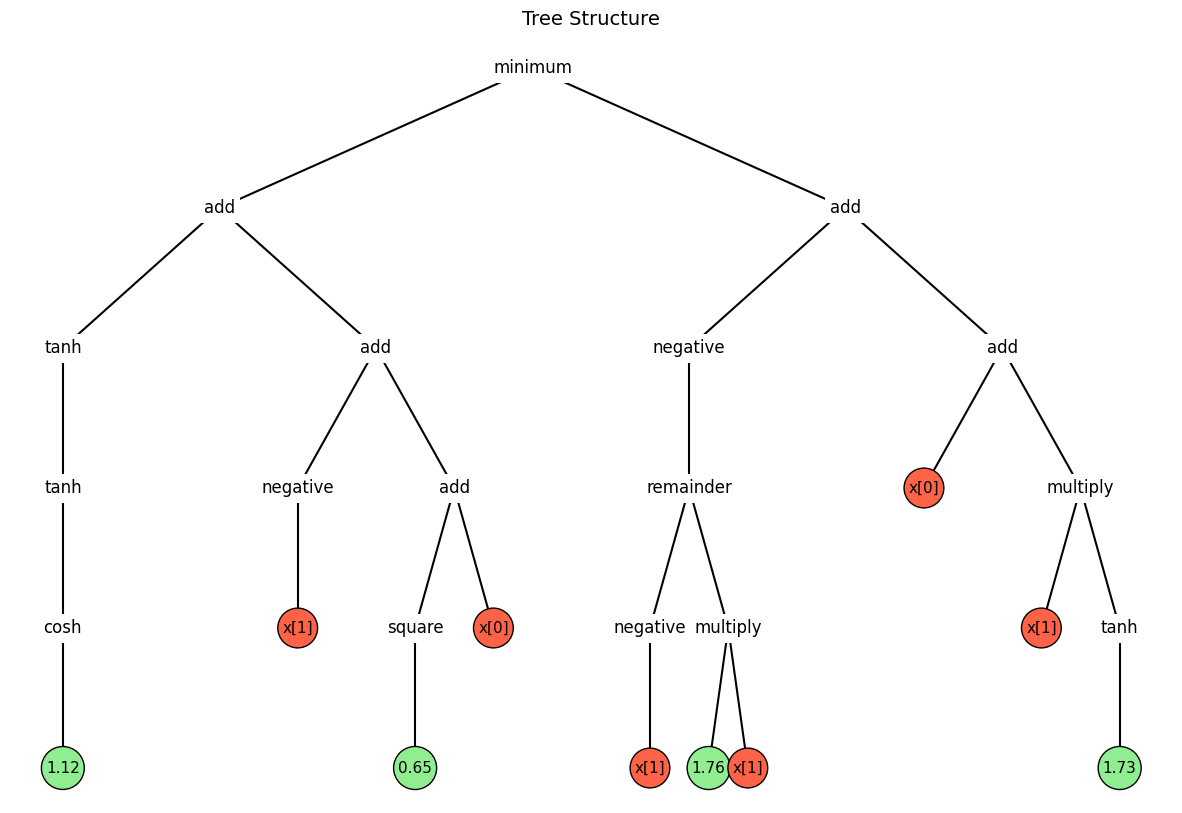

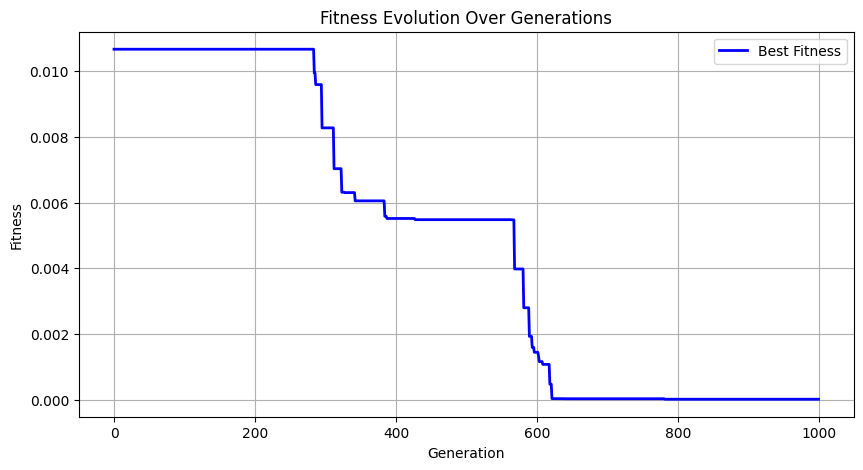

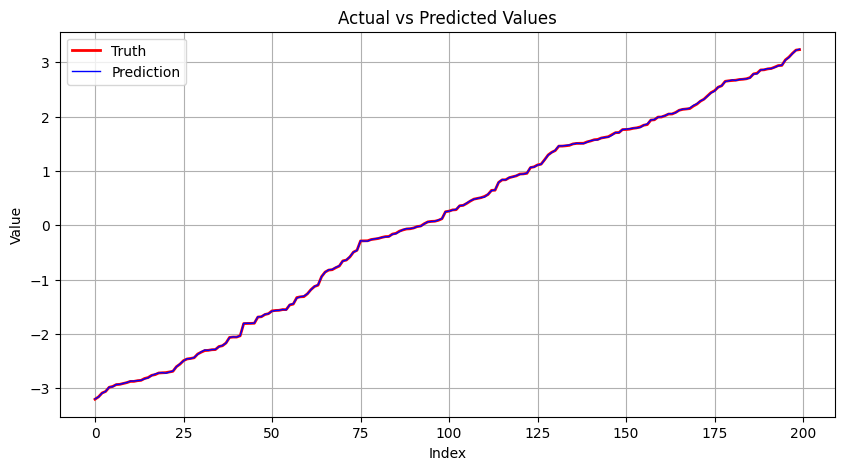

In [7]:
run_sym_reg_gp(0)

### Problem 1



Problem 1



Generations:  20%|██        | 202/1000 [00:14<00:40, 19.92it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  40%|████      | 402/1000 [00:25<00:37, 15.86it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  60%|██████    | 601/1000 [00:43<01:09,  5.76it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  80%|████████  | 801/1000 [01:15<00:31,  6.33it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations: 100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])

Best global formula:  np.sin(x[0])
Best training fitness:  7.588163980885709e-34
Best testing fitness:  5.277048047621027e-34


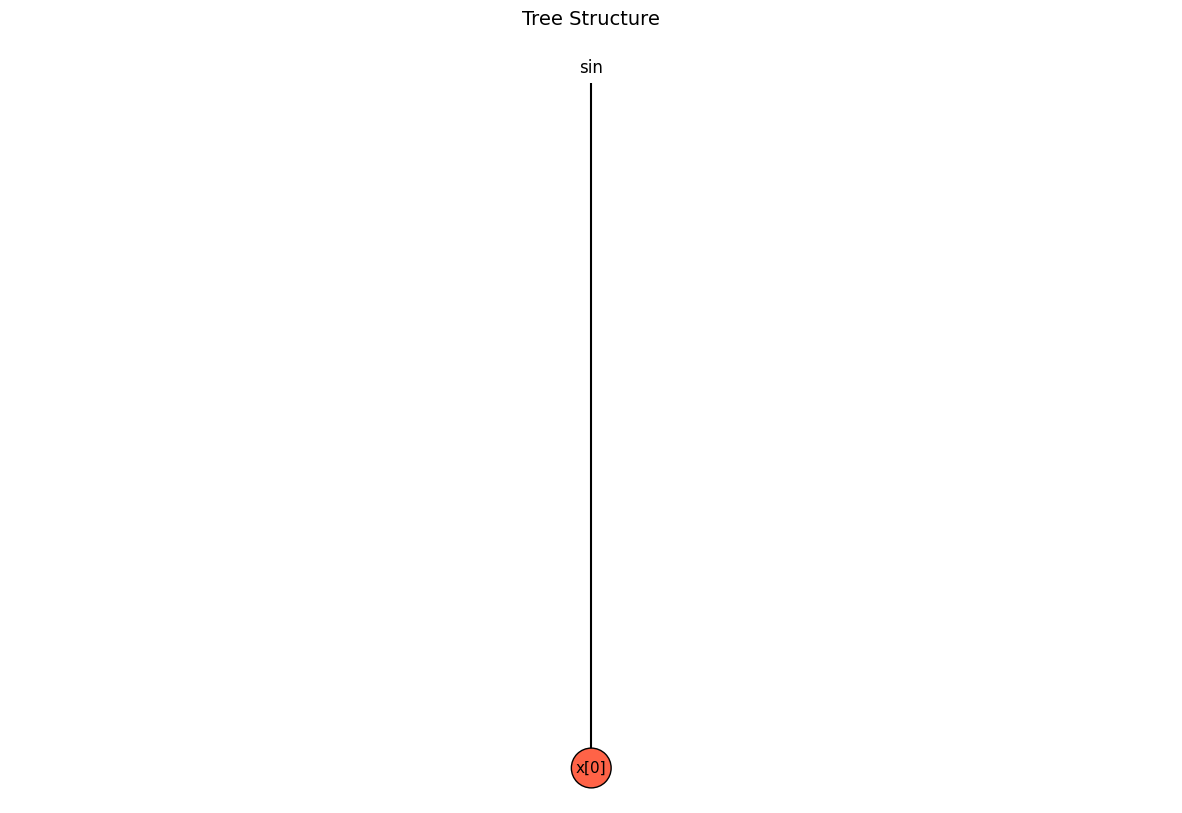

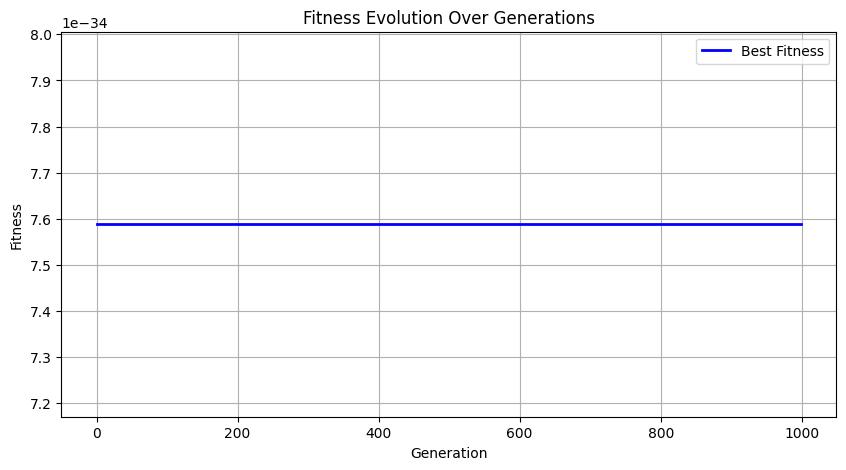

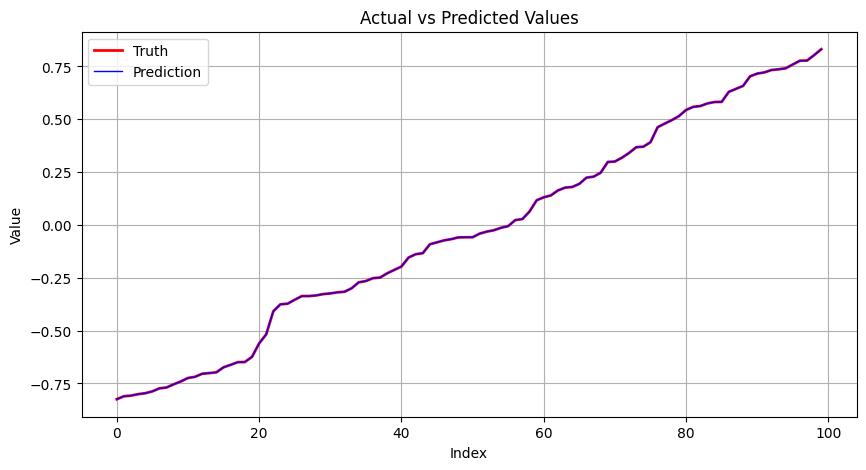

In [8]:
run_sym_reg_gp(1)

### Problem 2



Problem 2



Generations:  20%|██        | 200/1000 [01:04<03:48,  3.50it/s]

Generation 200:
    Island 1; Best fitness: 17792199552896.812500
    Island 2; Best fitness: 26420010157196.175781
    Island 3; Best fitness: 26725062888752.023438
    Island 4; Best fitness: 23551347087147.402344
    Island 5; Best fitness: 26743554056115.339844
    Best global fitness: 17792199552896.812500
    Best global formula: np.add(np.multiply(np.multiply(np.cosh(5.369873197780641), np.square(np.subtract(x[0], x[2]))), np.multiply(x[1], np.cosh(5.369873197780641))), np.multiply(np.multiply(np.square(4.991581697557442), x[0]), np.square(np.exp(5.369873197780641))))



Generations:  40%|████      | 400/1000 [02:03<03:16,  3.06it/s]

Generation 400:
    Island 1; Best fitness: 17712524375928.718750
    Island 2; Best fitness: 17714639127701.921875
    Island 3; Best fitness: 17708808584013.832031
    Island 4; Best fitness: 17709897988212.808594
    Island 5; Best fitness: 17712604467683.757812
    Best global fitness: 17708808584013.832031
    Best global formula: np.add(np.multiply(np.multiply(np.cosh(np.maximum(5.663668926140395, x[2])), np.square(np.subtract(x[0], x[2]))), np.multiply(x[1], np.sinh(5.3461280221000935))), np.multiply(np.multiply(np.square(4.910121096668122), x[0]), np.square(np.exp(5.369873197780641))))



Generations:  60%|██████    | 601/1000 [02:57<00:54,  7.37it/s]

Generation 600:
    Island 1; Best fitness: 17707520418236.570312
    Island 2; Best fitness: 17707454188581.152344
    Island 3; Best fitness: 17707518213428.402344
    Island 4; Best fitness: 17707520418236.570312
    Island 5; Best fitness: 17707520418236.570312
    Best global fitness: 17707454188581.152344
    Best global formula: np.add(np.multiply(np.multiply(np.cosh(-5.685932604748422), np.square(np.subtract(x[0], x[2]))), np.multiply(x[1], np.cosh(np.minimum(5.341162492534893, -5.328606270074232)))), np.multiply(np.multiply(np.square(-4.943296862710281), x[0]), np.square(np.exp(5.369873197780641))))



Generations:  80%|████████  | 802/1000 [03:23<00:20,  9.43it/s]

Generation 800:
    Island 1; Best fitness: 15223916235039.400391
    Island 2; Best fitness: 17707454188581.152344
    Island 3; Best fitness: 15370940095429.390625
    Island 4; Best fitness: 15192980829879.064453
    Island 5; Best fitness: 15156794064037.103516
    Best global fitness: 15156794064037.103516
    Best global formula: np.add(np.multiply(np.multiply(np.cosh(np.add(-2.4810459691398137, -3.4254029068941225)), np.multiply(np.add(x[2], x[2]), np.negative(x[0]))), np.multiply(x[1], np.exp(5.369873197780641))), np.multiply(np.multiply(np.square(-4.943296862710281), x[0]), np.square(np.exp(5.369873197780641))))



Generations: 100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]

Generation 1000:
    Island 1; Best fitness: 14921268596967.562500
    Island 2; Best fitness: 15157127400446.044922
    Island 3; Best fitness: 14921268596967.562500
    Island 4; Best fitness: 14921268596967.562500
    Island 5; Best fitness: 14921268596967.562500
    Best global fitness: 14921268596967.562500
    Best global formula: np.add(np.multiply(np.multiply(np.cosh(np.add(-2.6000121306461272, -3.2150906456657626)), np.multiply(np.add(x[2], x[2]), np.negative(x[0]))), np.multiply(x[1], np.subtract(np.exp(5.560625554341413), np.cosh(x[0])))), np.multiply(np.multiply(np.square(-4.943296862710281), x[0]), np.square(np.exp(5.369873197780641))))

Best global formula:  np.add(np.multiply(np.multiply(np.cosh(np.add(-2.6000121306461272, -3.2150906456657626)), np.multiply(np.add(x[2], x[2]), np.negative(x[0]))), np.multiply(x[1], np.subtract(np.exp(5.560625554341413), np.cosh(x[0])))), np.multiply(np.multiply(np.square(-4.943296862710281), x[0]), np.square(np.exp(5.369873197780641))))


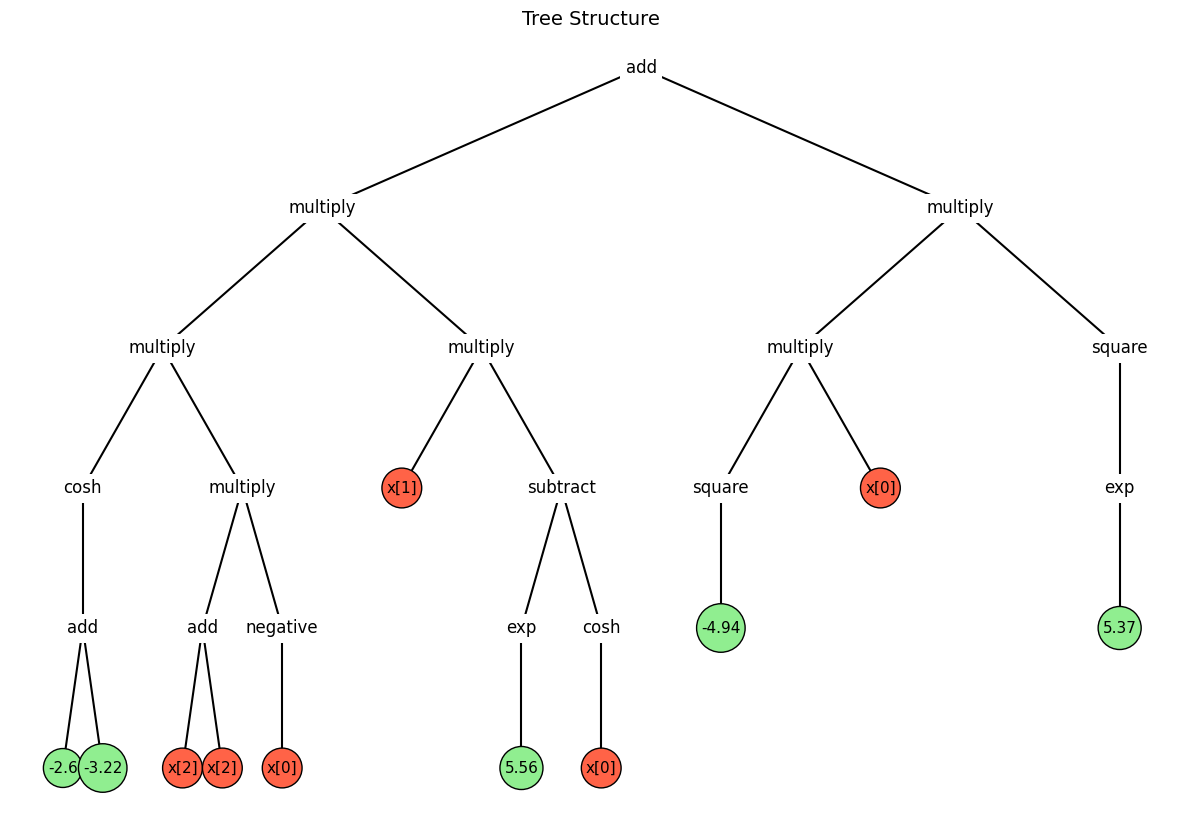

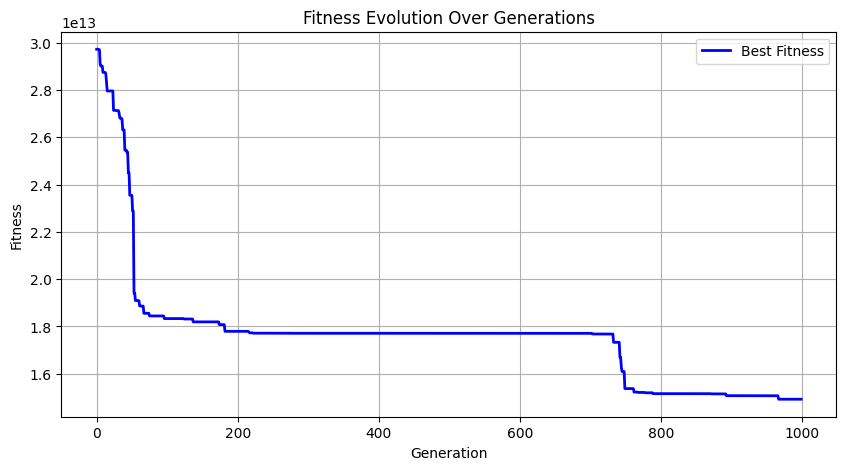

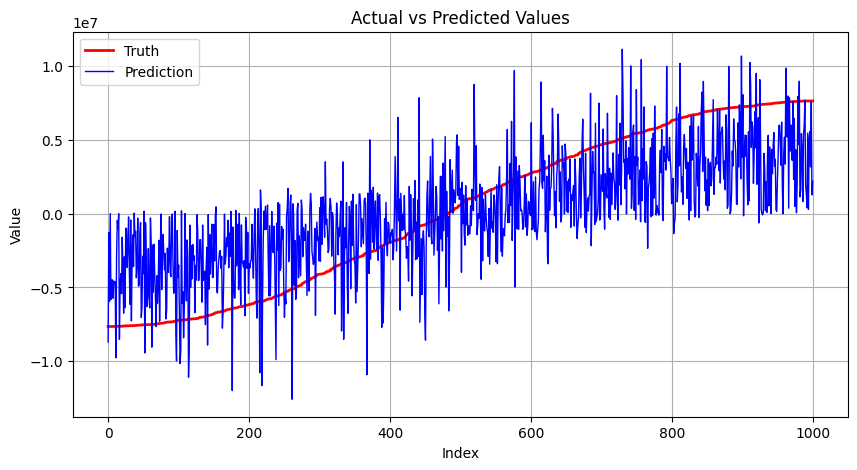

In [9]:
run_sym_reg_gp(2)

### Problem 3



Problem 3



Generations:  20%|██        | 200/1000 [00:38<03:00,  4.43it/s]

Generation 200:
    Island 1; Best fitness: 75.397622
    Island 2; Best fitness: 91.115632
    Island 3; Best fitness: 855.750093
    Island 4; Best fitness: 561.962547
    Island 5; Best fitness: 939.115682
    Best global fitness: 75.397622
    Best global formula: np.add(np.multiply(np.multiply(-5.131535631804009, np.cos(np.minimum(3.7832138552602874, -1.166098590091753))), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(2.3784533719972547, np.remainder(np.tanh(x[1]), np.add(x[2], x[1]))), np.add(np.cosh(x[0]), np.subtract(3.6239034734215867, x[2]))))



Generations:  40%|████      | 400/1000 [01:25<02:33,  3.90it/s]

Generation 400:
    Island 1; Best fitness: 68.076708
    Island 2; Best fitness: 72.635926
    Island 3; Best fitness: 67.017194
    Island 4; Best fitness: 60.195344
    Island 5; Best fitness: 73.123495
    Best global fitness: 60.195344
    Best global formula: np.add(np.multiply(np.multiply(-4.742345497782325, np.cos(-1.166098590091753)), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(np.negative(np.maximum(-4.259478668898824, x[1])), np.remainder(x[1], -4.742345497782325)), np.add(np.cosh(x[0]), np.subtract(3.6239034734215867, x[2]))))



Generations:  60%|██████    | 600/1000 [02:18<01:32,  4.31it/s]

Generation 600:
    Island 1; Best fitness: 47.881648
    Island 2; Best fitness: 68.056292
    Island 3; Best fitness: 59.311851
    Island 4; Best fitness: 43.674397
    Island 5; Best fitness: 47.730541
    Best global fitness: 43.674397
    Best global formula: np.add(np.multiply(np.multiply(-4.545991072645782, np.cos(-1.166098590091753)), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(np.negative(np.multiply(x[1], 2.055937107636824)), -4.742345497782325), np.add(np.cosh(np.divide(x[0], -1.0814122259190357)), np.subtract(np.absolute(x[0]), x[2]))))



Generations:  80%|████████  | 801/1000 [02:57<00:29,  6.71it/s]

Generation 800:
    Island 1; Best fitness: 37.775938
    Island 2; Best fitness: 46.387541
    Island 3; Best fitness: 47.627762
    Island 4; Best fitness: 37.646460
    Island 5; Best fitness: 33.635012
    Best global fitness: 33.635012
    Best global formula: np.add(np.multiply(np.multiply(-4.545991072645782, np.cos(-1.166098590091753)), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(np.negative(np.multiply(x[1], 2.055937107636824)), np.add(-4.545991072645782, x[2])), np.add(np.cosh(np.divide(x[0], -1.0814122259190357)), np.subtract(np.absolute(x[0]), np.add(-2.650073775222249, x[2])))))



Generations: 100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


Generation 1000:
    Island 1; Best fitness: 29.816198
    Island 2; Best fitness: 37.285116
    Island 3; Best fitness: 37.285116
    Island 4; Best fitness: 37.285116
    Island 5; Best fitness: 29.816198
    Best global fitness: 29.816198
    Best global formula: np.add(np.multiply(np.multiply(-4.545991072645782, np.cos(-1.166098590091753)), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(np.negative(np.multiply(x[1], 2.055937107636824)), np.add(-4.804168082064881, x[2])), np.add(np.cosh(np.divide(x[0], -1.0814122259190357)), np.subtract(np.absolute(x[0]), np.remainder(x[1], -4.562096723325096)))))

Best global formula:  np.add(np.multiply(np.multiply(-4.545991072645782, np.cos(-1.166098590091753)), np.subtract(np.add(x[2], np.exp(x[1])), np.absolute(np.cosh(x[1])))), np.add(np.subtract(np.negative(np.multiply(x[1], 2.055937107636824)), np.add(-4.804168082064881, x[2])), np.add(np.cosh(np.divide(x[0], -1.0814122259190357)), np.subtract(np.abs

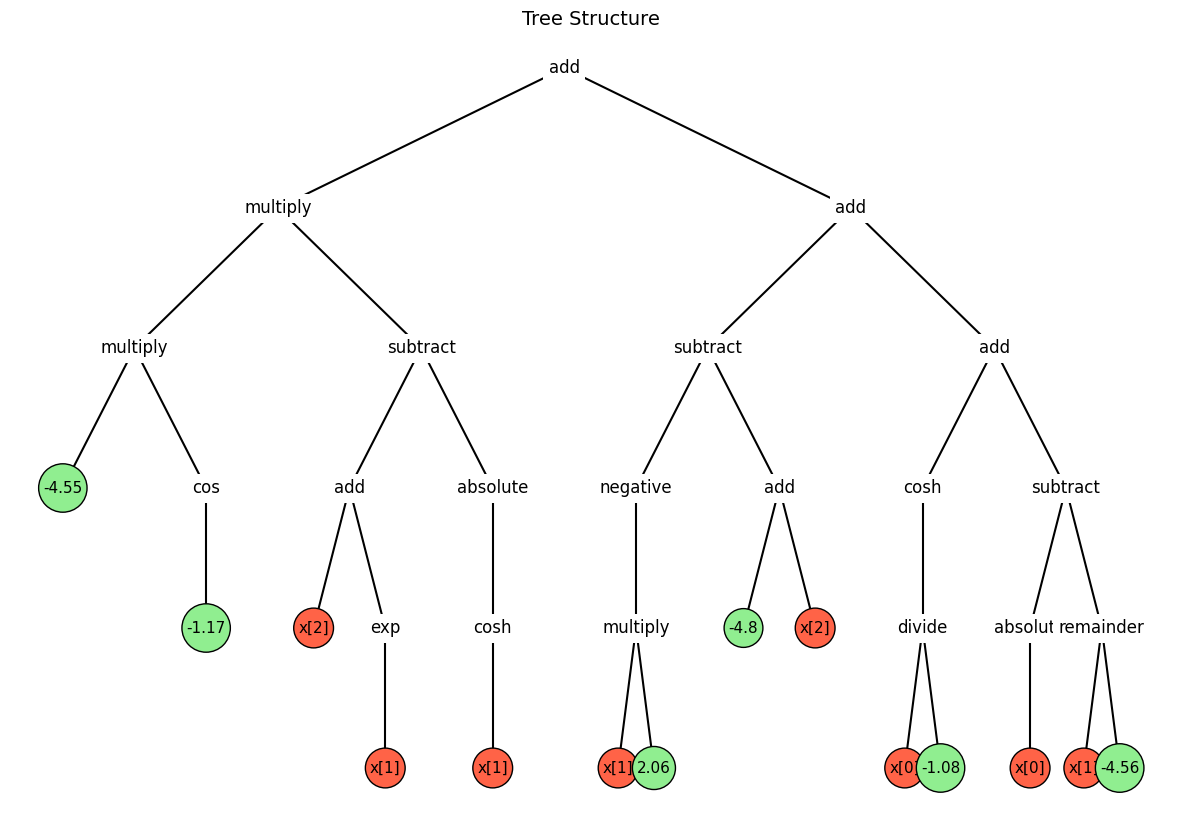

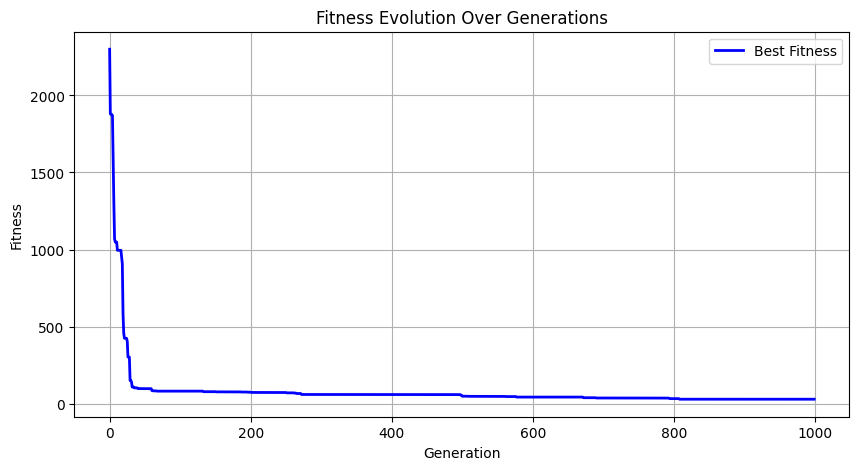

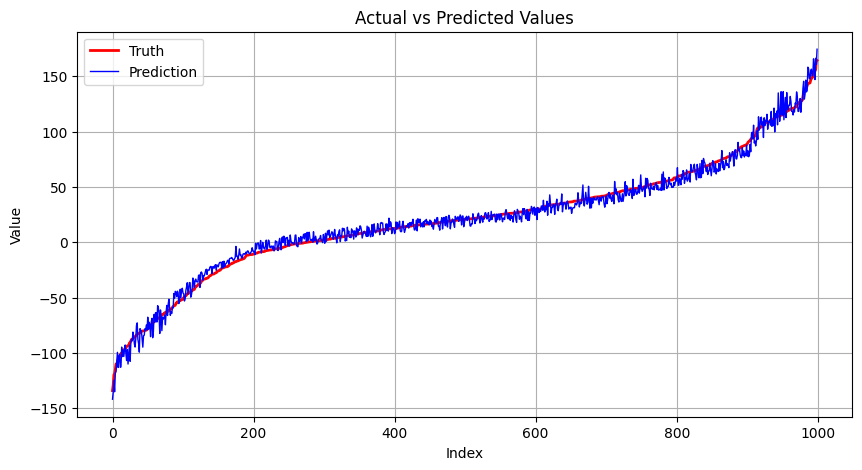

In [10]:
run_sym_reg_gp(3)

### Problem 4



Problem 4



Generations:  20%|██        | 201/1000 [00:26<01:21,  9.76it/s]

Generation 200:
    Island 1; Best fitness: 13.331819
    Island 2; Best fitness: 0.138443
    Island 3; Best fitness: 19.265148
    Island 4; Best fitness: 11.605818
    Island 5; Best fitness: 10.833859
    Best global fitness: 0.138443
    Best global formula: np.add(np.add(np.add(np.cos(x[1]), np.cos(x[1])), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(x[1]), np.cos(x[1])), np.subtract(np.cos(x[1]), -3.5409779945674837)))



Generations:  40%|████      | 400/1000 [01:09<02:10,  4.61it/s]

Generation 400:
    Island 1; Best fitness: 0.083551
    Island 2; Best fitness: 0.077530
    Island 3; Best fitness: 0.104937
    Island 4; Best fitness: 0.122821
    Island 5; Best fitness: 0.122821
    Best global fitness: 0.077530
    Best global formula: np.add(np.add(np.add(np.cos(x[1]), np.cos(np.minimum(4.916722381334848, x[1]))), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(x[1]), np.cos(x[1])), np.subtract(np.sinh(np.cos(x[1])), np.log2(np.exp(-2.3012143417365962)))))



Generations:  60%|██████    | 600/1000 [01:59<01:26,  4.62it/s]

Generation 600:
    Island 1; Best fitness: 0.070791
    Island 2; Best fitness: 0.077530
    Island 3; Best fitness: 0.077530
    Island 4; Best fitness: 0.077530
    Island 5; Best fitness: 0.077530
    Best global fitness: 0.070791
    Best global formula: np.add(np.add(np.add(np.sin(np.cos(x[1])), np.cos(np.minimum(4.916722381334848, x[1]))), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(x[1]), np.cos(x[1])), np.subtract(np.sinh(np.cos(x[1])), np.log2(np.exp(-2.3012143417365962)))))



Generations:  80%|████████  | 800/1000 [02:58<00:50,  3.94it/s]

Generation 800:
    Island 1; Best fitness: 0.069164
    Island 2; Best fitness: 0.069164
    Island 3; Best fitness: 0.069164
    Island 4; Best fitness: 0.069164
    Island 5; Best fitness: 0.069164
    Best global fitness: 0.069164
    Best global formula: np.add(np.add(np.add(np.sin(np.cos(x[1])), np.cos(np.minimum(x[1], x[1]))), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(x[1]), np.cos(x[1])), np.subtract(np.sinh(np.cos(x[1])), np.add(-3.8176015332518403, np.power(0.5905406461535465, 1.1707846494319254)))))



Generations: 100%|██████████| 1000/1000 [03:56<00:00,  4.24it/s]

Generation 1000:
    Island 1; Best fitness: 0.069125
    Island 2; Best fitness: 0.069164
    Island 3; Best fitness: 0.069162
    Island 4; Best fitness: 0.069162
    Island 5; Best fitness: 0.069125
    Best global fitness: 0.069125
    Best global formula: np.add(np.add(np.add(np.sin(np.cos(x[1])), np.cos(np.minimum(x[1], x[1]))), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(np.subtract(x[1], 0.010079400223165003)), np.cos(x[1])), np.subtract(np.sinh(np.cos(x[1])), np.add(-3.8176015332518403, np.power(0.5905406461535465, 1.1707846494319254)))))

Best global formula:  np.add(np.add(np.add(np.sin(np.cos(x[1])), np.cos(np.minimum(x[1], x[1]))), np.add(np.cos(x[1]), np.cos(x[1]))), np.add(np.add(np.cos(np.subtract(x[1], 0.010079400223165003)), np.cos(x[1])), np.subtract(np.sinh(np.cos(x[1])), np.add(-3.8176015332518403, np.power(0.5905406461535465, 1.1707846494319254)))))
Best training fitness:  0.06912461736535398
Best testing fitness:  0.06603970421945048


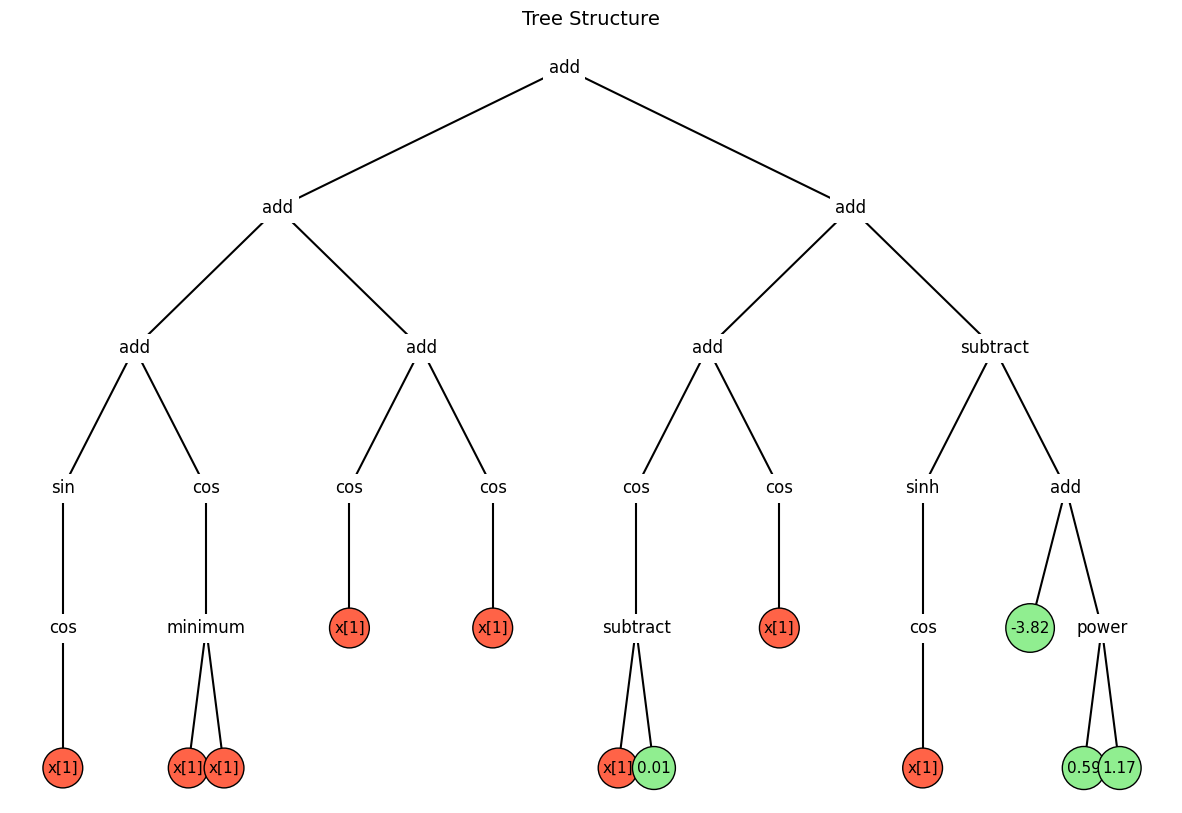

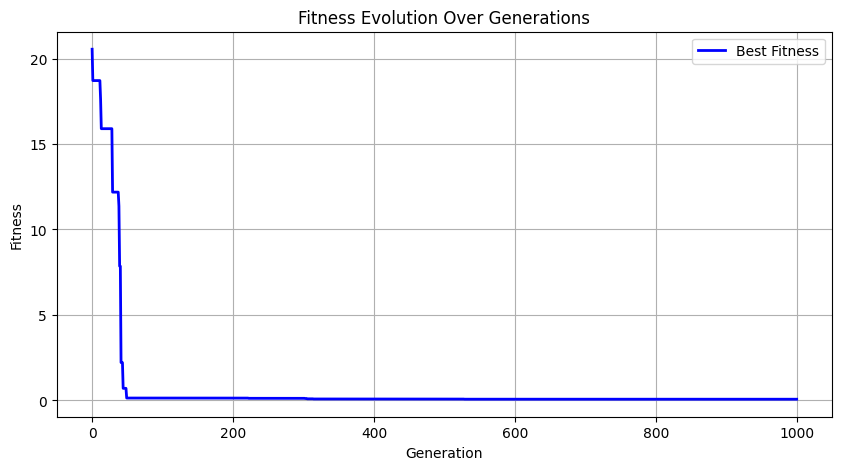

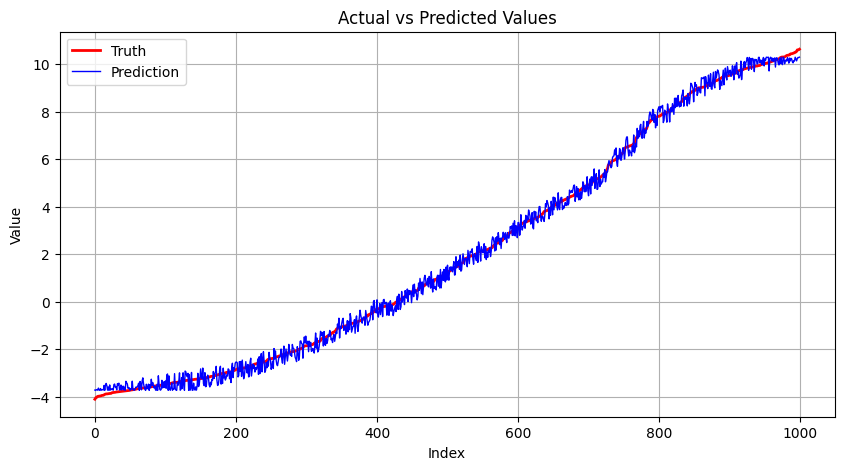

In [11]:
run_sym_reg_gp(4)

### Problem 5



Problem 5



Generations:  20%|██        | 200/1000 [00:31<02:17,  5.81it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.power(np.power(1.7093989053434098, 5.206186702518516), x[1]), -6.027046665958086e-15)



Generations:  40%|████      | 401/1000 [01:08<01:27,  6.82it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.power(np.subtract(np.subtract(np.square(x[0]), np.remainder(4.213465894896135, x[0])), np.negative(x[0])), np.minimum(np.multiply(np.power(1.970013106305561, 2.6621665551007516), np.tanh(1.093554501388417)), np.minimum(np.exp(x[0]), x[1]))), -6.027046665958086e-15)



Generations:  60%|██████    | 601/1000 [01:46<01:14,  5.32it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(-6.027046665958086e-15, np.power(np.add(np.power(np.divide(x[0], 0.5130358016128974), np.arctan(x[1])), np.power(np.square(-0.2551482642366941), np.cos(x[1]))), x[1]))



Generations:  80%|████████  | 801/1000 [02:29<00:35,  5.58it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(-6.027046665958086e-15, np.power(np.add(np.power(np.divide(x[0], 0.5130358016128974), np.arctan(5.109989894547273)), np.power(0.06510063674299789, np.cos(x[1]))), np.add(np.multiply(np.subtract(5.061849862519098, x[1]), 0.06510063674299789), x[1])))



Generations: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(-6.027046665958086e-15, np.power(np.add(np.power(np.divide(x[0], 0.5130358016128974), np.arctan(5.079953468300546)), np.power(0.06510063674299789, np.cos(x[1]))), np.add(np.multiply(np.subtract(5.061849862519098, x[1]), 0.06510063674299789), x[1])))

Best global formula:  np.multiply(-6.027046665958086e-15, np.power(np.add(np.power(np.divide(x[0], 0.5130358016128974), np.arctan(5.079953468300546)), np.power(0.06510063674299789, np.cos(x[1]))), np.add(np.multiply(np.subtract(5.061849862519098, x[1]), 0.06510063674299789), x[1])))
Best training fitness:  1.6398871573644924e-19
Best testing fitness:  1.555437402366955e-19


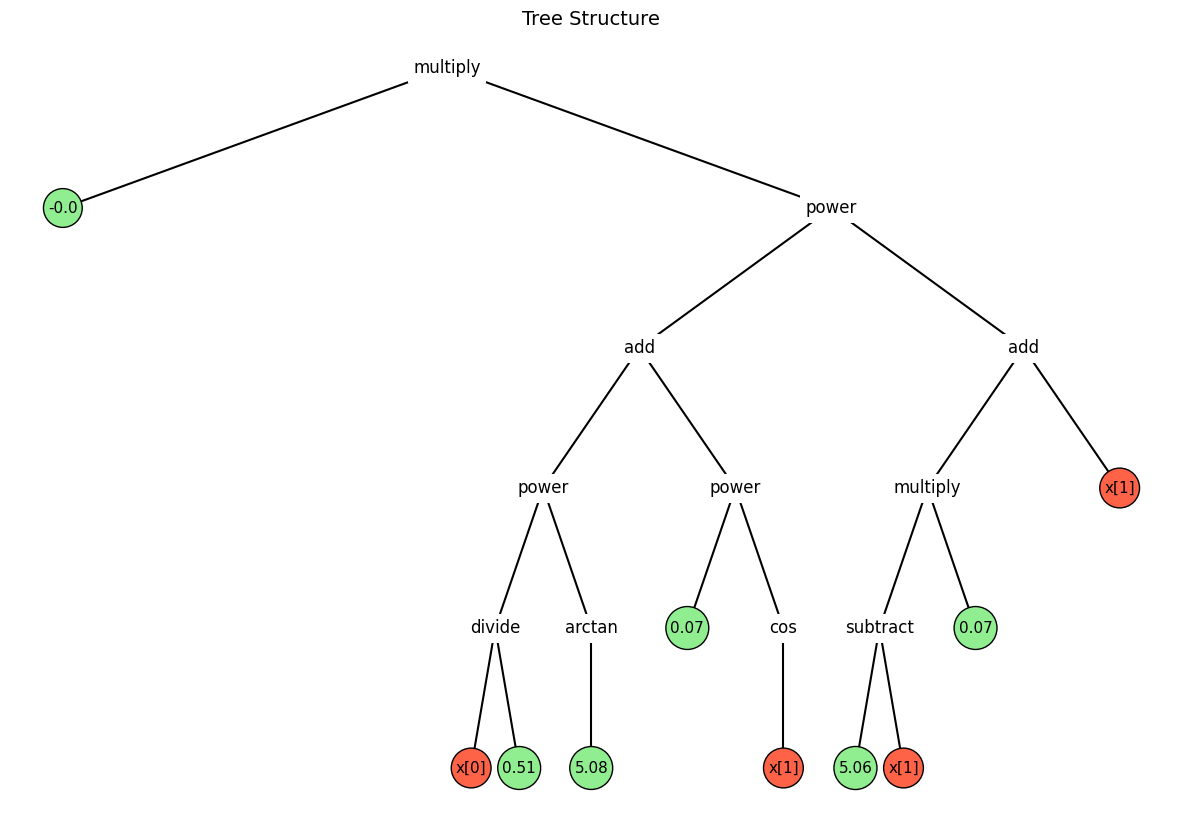

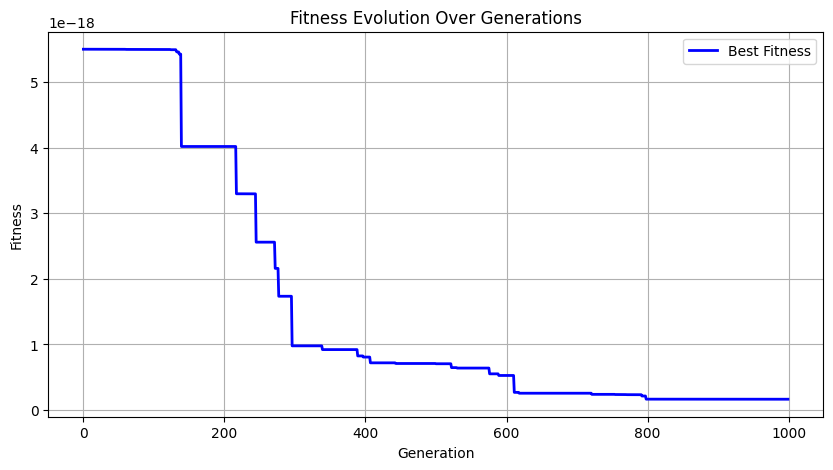

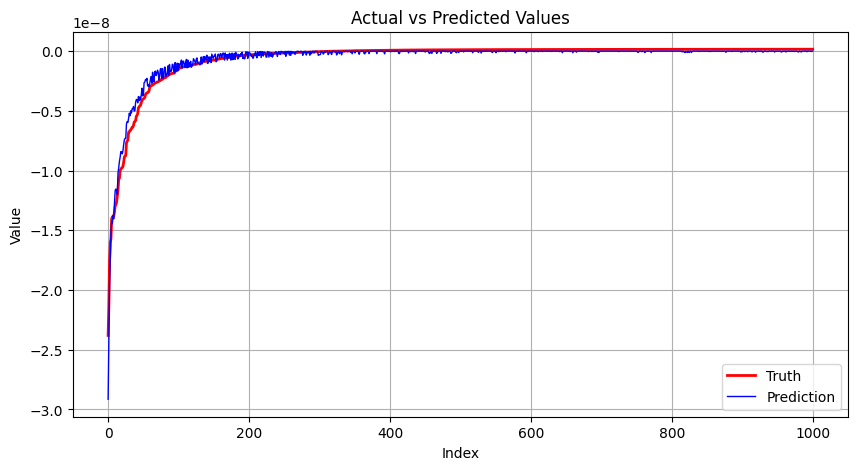

In [12]:
run_sym_reg_gp(5)

### Problem 6



Problem 6



Generations:  20%|██        | 201/1000 [00:24<01:55,  6.91it/s]

Generation 200:
    Island 1; Best fitness: 0.253235
    Island 2; Best fitness: 0.352607
    Island 3; Best fitness: 0.396400
    Island 4; Best fitness: 0.746608
    Island 5; Best fitness: 0.923973
    Best global fitness: 0.253235
    Best global formula: np.add(np.negative(np.subtract(x[0], np.cbrt(np.subtract(x[0], x[1])))), np.add(x[1], x[1]))



Generations:  40%|████      | 402/1000 [00:48<01:19,  7.49it/s]

Generation 400:
    Island 1; Best fitness: 0.204232
    Island 2; Best fitness: 0.223323
    Island 3; Best fitness: 0.223323
    Island 4; Best fitness: 0.223323
    Island 5; Best fitness: 0.223296
    Best global fitness: 0.204232
    Best global formula: np.add(np.negative(np.subtract(np.minimum(x[0], 3.8161333663025134), np.arctan(np.subtract(x[0], x[1])))), np.add(x[1], x[1]))



Generations:  60%|██████    | 601/1000 [01:15<00:51,  7.78it/s]

Generation 600:
    Island 1; Best fitness: 0.197706
    Island 2; Best fitness: 0.197706
    Island 3; Best fitness: 0.197564
    Island 4; Best fitness: 0.197571
    Island 5; Best fitness: 0.197529
    Best global fitness: 0.197529
    Best global formula: np.add(np.add(np.minimum(np.cbrt(np.exp(x[1])), np.minimum(1.8961810844464175, x[1])), x[1]), np.negative(np.subtract(np.minimum(4.086571527089265, x[0]), np.arctan(np.subtract(x[0], x[1])))))



Generations:  80%|████████  | 802/1000 [01:44<00:22,  8.94it/s]

Generation 800:
    Island 1; Best fitness: 0.177613
    Island 2; Best fitness: 0.177613
    Island 3; Best fitness: 0.177283
    Island 4; Best fitness: 0.177613
    Island 5; Best fitness: 0.177532
    Best global fitness: 0.177283
    Best global formula: np.add(np.add(x[1], np.maximum(x[1], np.negative(np.power(1.6425591415215521, 2.8701414427886975)))), np.negative(np.subtract(np.minimum(x[0], 4.226289548472352), np.arctan(np.subtract(x[0], x[1])))))



Generations: 100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]

Generation 1000:
    Island 1; Best fitness: 0.172853
    Island 2; Best fitness: 0.177171
    Island 3; Best fitness: 0.172853
    Island 4; Best fitness: 0.172853
    Island 5; Best fitness: 0.172853
    Best global fitness: 0.172853
    Best global formula: np.add(np.add(x[1], np.maximum(np.subtract(x[1], 0.0715542326500378), np.negative(4.120292756672327))), np.negative(np.subtract(np.minimum(x[0], 4.155045641154721), np.arctan(np.subtract(x[0], x[1])))))

Best global formula:  np.add(np.add(x[1], np.maximum(np.subtract(x[1], 0.0715542326500378), np.negative(4.120292756672327))), np.negative(np.subtract(np.minimum(x[0], 4.155045641154721), np.arctan(np.subtract(x[0], x[1])))))
Best training fitness:  0.1728529273915435
Best testing fitness:  0.16866286130732033


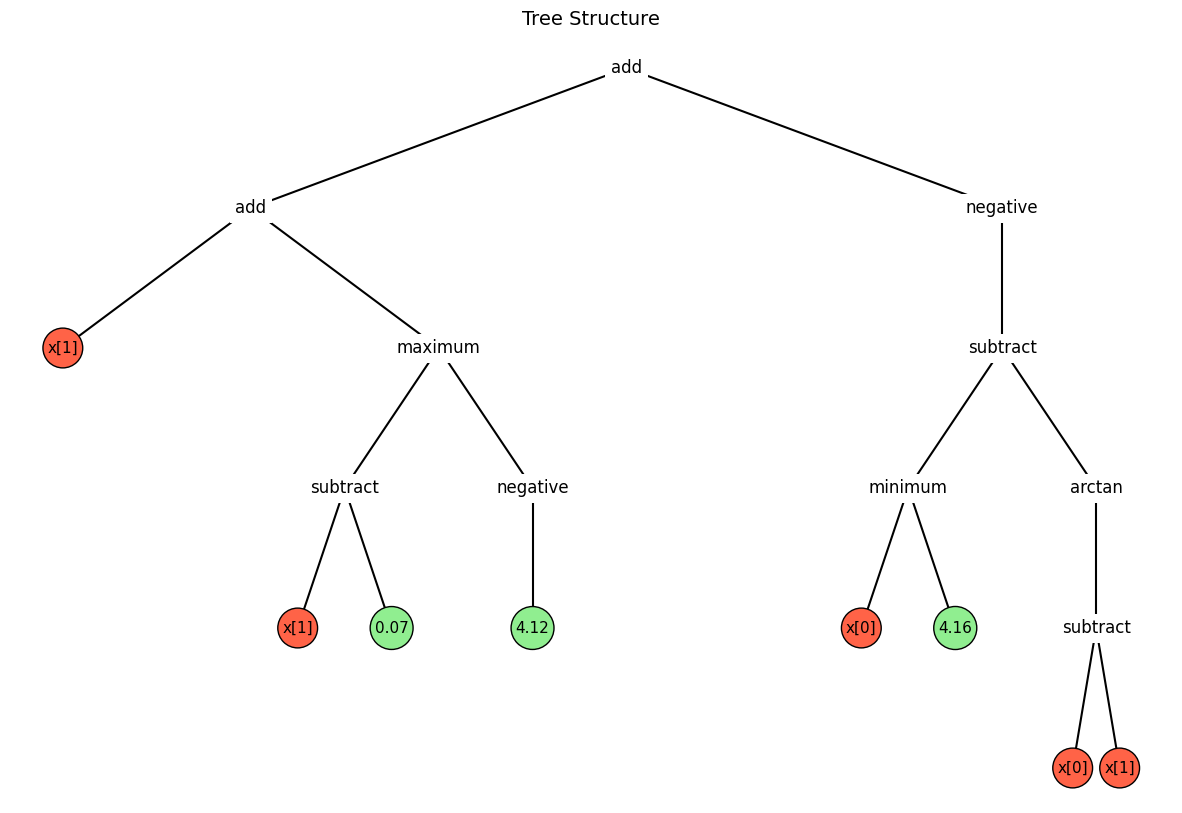

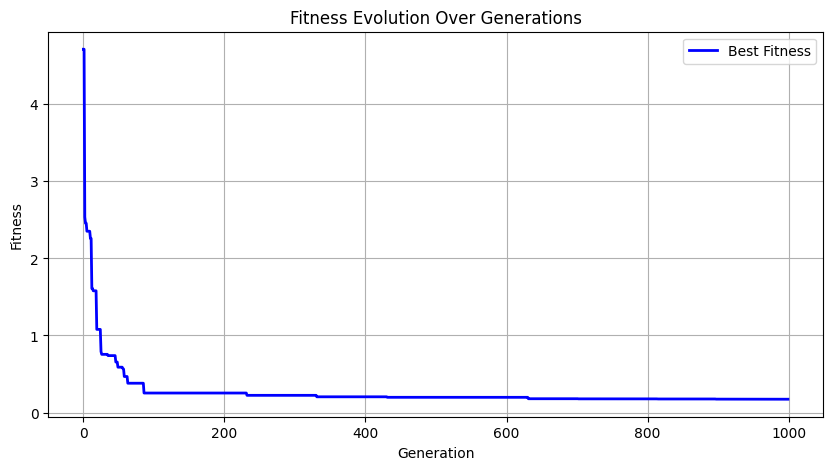

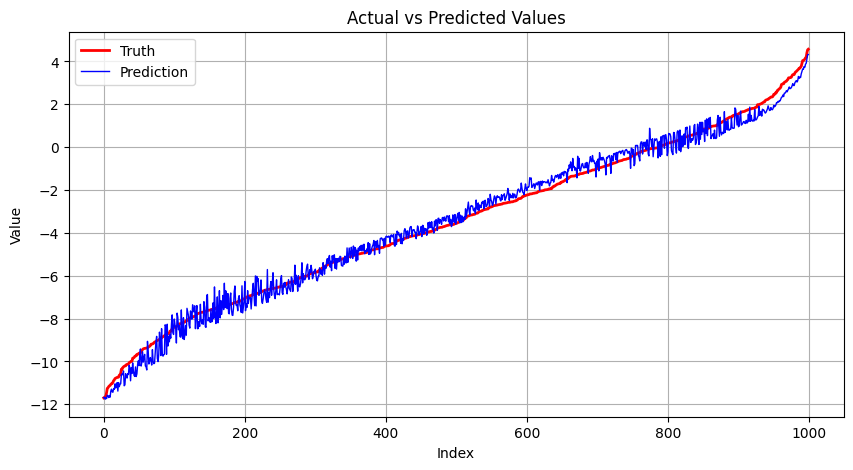

In [13]:
run_sym_reg_gp(6)

### Problem 7



Problem 7



Generations:  20%|██        | 200/1000 [00:36<02:29,  5.35it/s]

Generation 200:
    Island 1; Best fitness: 339.140896
    Island 2; Best fitness: 353.936895
    Island 3; Best fitness: 338.200416
    Island 4; Best fitness: 327.652951
    Island 5; Best fitness: 372.941357
    Best global fitness: 327.652951
    Best global formula: np.cosh(np.subtract(np.multiply(np.minimum(np.absolute(x[0]), x[1]), x[0]), np.negative(2.2821096012221727)))



Generations:  40%|████      | 401/1000 [01:08<01:18,  7.59it/s]

Generation 400:
    Island 1; Best fitness: 327.652951
    Island 2; Best fitness: 336.281634
    Island 3; Best fitness: 307.949710
    Island 4; Best fitness: 322.478888
    Island 5; Best fitness: 327.608790
    Best global fitness: 307.949710
    Best global formula: np.multiply(np.exp(np.sin(np.cosh(x[1]))), np.power(np.exp(x[1]), np.add(np.tanh(np.maximum(-0.8994923234342136, x[0])), np.minimum(np.absolute(x[1]), x[0]))))



Generations:  60%|██████    | 601/1000 [01:32<01:01,  6.49it/s]

Generation 600:
    Island 1; Best fitness: 301.226946
    Island 2; Best fitness: 314.814953
    Island 3; Best fitness: 301.226946
    Island 4; Best fitness: 301.226944
    Island 5; Best fitness: 301.226946
    Best global fitness: 301.226944
    Best global formula: np.multiply(np.exp(np.sin(np.cosh(np.minimum(1.8537698499292565, x[1])))), np.power(np.exp(x[1]), np.add(np.tanh(np.maximum(-0.8994923234342136, x[0])), np.minimum(np.maximum(-0.3143182268148652, x[1]), x[0]))))



Generations:  80%|████████  | 801/1000 [02:00<00:27,  7.16it/s]

Generation 800:
    Island 1; Best fitness: 301.226944
    Island 2; Best fitness: 301.226945
    Island 3; Best fitness: 281.039642
    Island 4; Best fitness: 301.226944
    Island 5; Best fitness: 301.226944
    Best global fitness: 281.039642
    Best global formula: np.multiply(np.exp(np.sin(np.cosh(np.minimum(1.8537698499292565, x[1])))), np.power(np.exp(x[1]), np.add(np.tanh(np.maximum(-1.3819979974952137, x[0])), np.minimum(np.maximum(-0.31490631289263105, x[1]), np.maximum(-1.6742554726523684, x[0])))))



Generations: 100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


Generation 1000:
    Island 1; Best fitness: 280.592353
    Island 2; Best fitness: 301.219784
    Island 3; Best fitness: 280.592353
    Island 4; Best fitness: 280.592353
    Island 5; Best fitness: 280.592353
    Best global fitness: 280.592353
    Best global formula: np.multiply(np.exp(np.sin(np.cosh(np.minimum(1.8537698499292565, x[1])))), np.power(np.exp(x[1]), np.add(np.tanh(np.maximum(-1.3819979974952137, x[0])), np.minimum(np.maximum(-0.3072630359351072, x[1]), np.maximum(-1.6618842110811194, x[0])))))

Best global formula:  np.multiply(np.exp(np.sin(np.cosh(np.minimum(1.8537698499292565, x[1])))), np.power(np.exp(x[1]), np.add(np.tanh(np.maximum(-1.3819979974952137, x[0])), np.minimum(np.maximum(-0.3072630359351072, x[1]), np.maximum(-1.6618842110811194, x[0])))))
Best training fitness:  280.5923533230895
Best testing fitness:  287.6184890387306


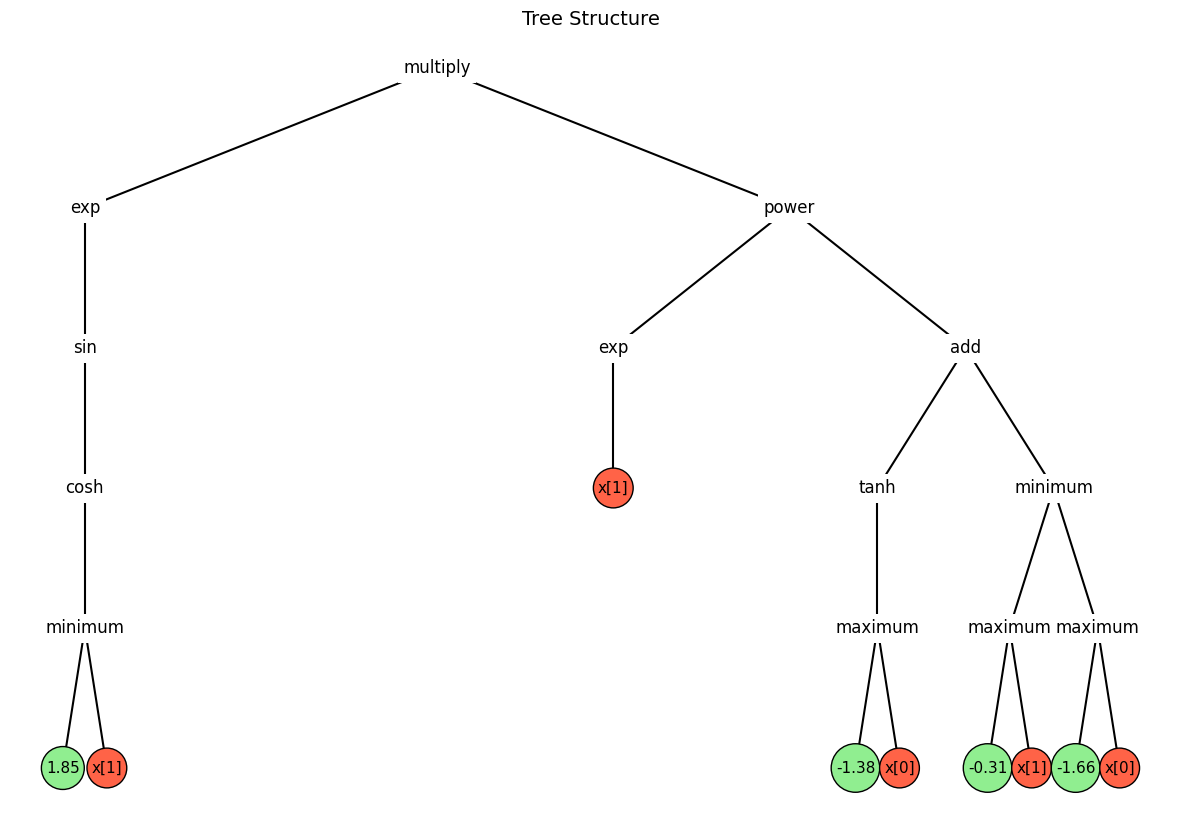

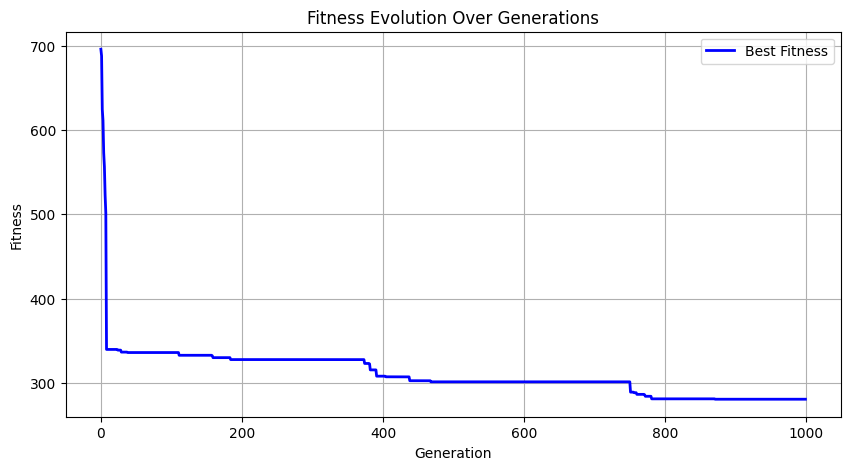

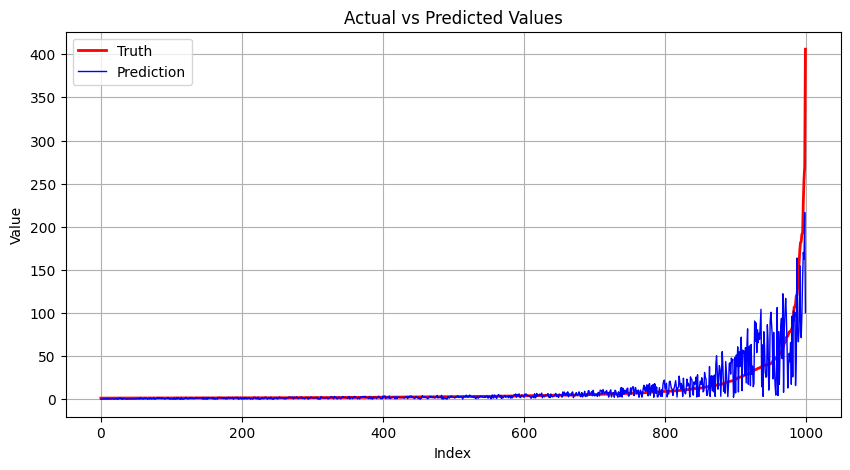

In [14]:
run_sym_reg_gp(7)

### Problem 8



Problem 8



Generations:  20%|██        | 200/1000 [03:33<23:34,  1.77s/it]

Generation 200:
    Island 1; Best fitness: 2122262.189510
    Island 2; Best fitness: 1550515.599036
    Island 3; Best fitness: 645568.427945
    Island 4; Best fitness: 1962438.353800
    Island 5; Best fitness: 552021.433136
    Best global fitness: 552021.433136
    Best global formula: np.multiply(np.add(np.sinh(np.negative(x[5])), np.square(np.cbrt(x[4]))), np.add(np.multiply(np.multiply(-5.225190448882802, 5.593325386259046), 5.593325386259046), np.multiply(np.absolute(np.absolute(x[5])), np.tan(np.divide(4.969306768109579, 0.20976917468075218)))))



Generations:  40%|████      | 400/1000 [06:30<08:51,  1.13it/s]

Generation 400:
    Island 1; Best fitness: 294094.267735
    Island 2; Best fitness: 1548962.125489
    Island 3; Best fitness: 622673.917189
    Island 4; Best fitness: 636966.460154
    Island 5; Best fitness: 314162.365147
    Best global fitness: 294094.267735
    Best global formula: np.multiply(np.add(np.sinh(np.negative(x[5])), np.sinh(np.cbrt(np.square(x[4])))), np.add(np.multiply(np.multiply(-5.225190448882802, 5.593325386259046), 5.593325386259046), np.multiply(np.absolute(np.absolute(x[5])), np.tan(np.log(5.44235002597283)))))



Generations:  60%|██████    | 600/1000 [09:58<07:29,  1.12s/it]

Generation 600:
    Island 1; Best fitness: 294094.267735
    Island 2; Best fitness: 294094.267735
    Island 3; Best fitness: 294094.267735
    Island 4; Best fitness: 294094.267735
    Island 5; Best fitness: 294044.710518
    Best global fitness: 294044.710518
    Best global formula: np.multiply(np.add(np.sinh(np.negative(x[5])), np.sinh(np.cbrt(np.square(x[4])))), np.add(np.multiply(np.multiply(-5.225190448882802, 5.579159019728722), 5.593325386259046), np.multiply(np.absolute(np.absolute(x[5])), np.tan(np.log(5.44235002597283)))))



Generations:  80%|████████  | 800/1000 [13:42<03:21,  1.01s/it]

Generation 800:
    Island 1; Best fitness: 247211.394064
    Island 2; Best fitness: 269203.345125
    Island 3; Best fitness: 269203.345125
    Island 4; Best fitness: 269203.345125
    Island 5; Best fitness: 269203.345125
    Best global fitness: 247211.394064
    Best global formula: np.multiply(np.add(np.sinh(np.negative(x[5])), np.sinh(np.cbrt(np.square(x[4])))), np.add(np.multiply(np.multiply(-5.271276467270128, 5.593325386259046), 5.593325386259046), np.multiply(np.absolute(np.add(0.7098169053893928, x[5])), np.divide(np.square(x[5]), np.tan(-4.398454148403825)))))



Generations: 100%|██████████| 1000/1000 [17:07<00:00,  1.03s/it]

Generation 1000:
    Island 1; Best fitness: 202996.599725
    Island 2; Best fitness: 202996.599725
    Island 3; Best fitness: 202996.599725
    Island 4; Best fitness: 202996.599725
    Island 5; Best fitness: 202996.599725
    Best global fitness: 202996.599725
    Best global formula: np.multiply(np.add(np.sinh(np.negative(x[5])), np.sinh(np.cbrt(np.square(x[4])))), np.add(np.multiply(np.multiply(-5.225190448882802, np.add(5.7514722132214136, -0.15288156941239528)), np.add(5.7514722132214136, np.cos(x[5]))), np.multiply(np.absolute(np.add(0.7098169053893928, x[5])), np.tan(np.log(5.393727864805511)))))

Best global formula:  np.multiply(np.add(np.sinh(np.negative(x[5])), np.sinh(np.cbrt(np.square(x[4])))), np.add(np.multiply(np.multiply(-5.225190448882802, np.add(5.7514722132214136, -0.15288156941239528)), np.add(5.7514722132214136, np.cos(x[5]))), np.multiply(np.absolute(np.add(0.7098169053893928, x[5])), np.tan(np.log(5.393727864805511)))))
Best training fitness:  202996.5997252

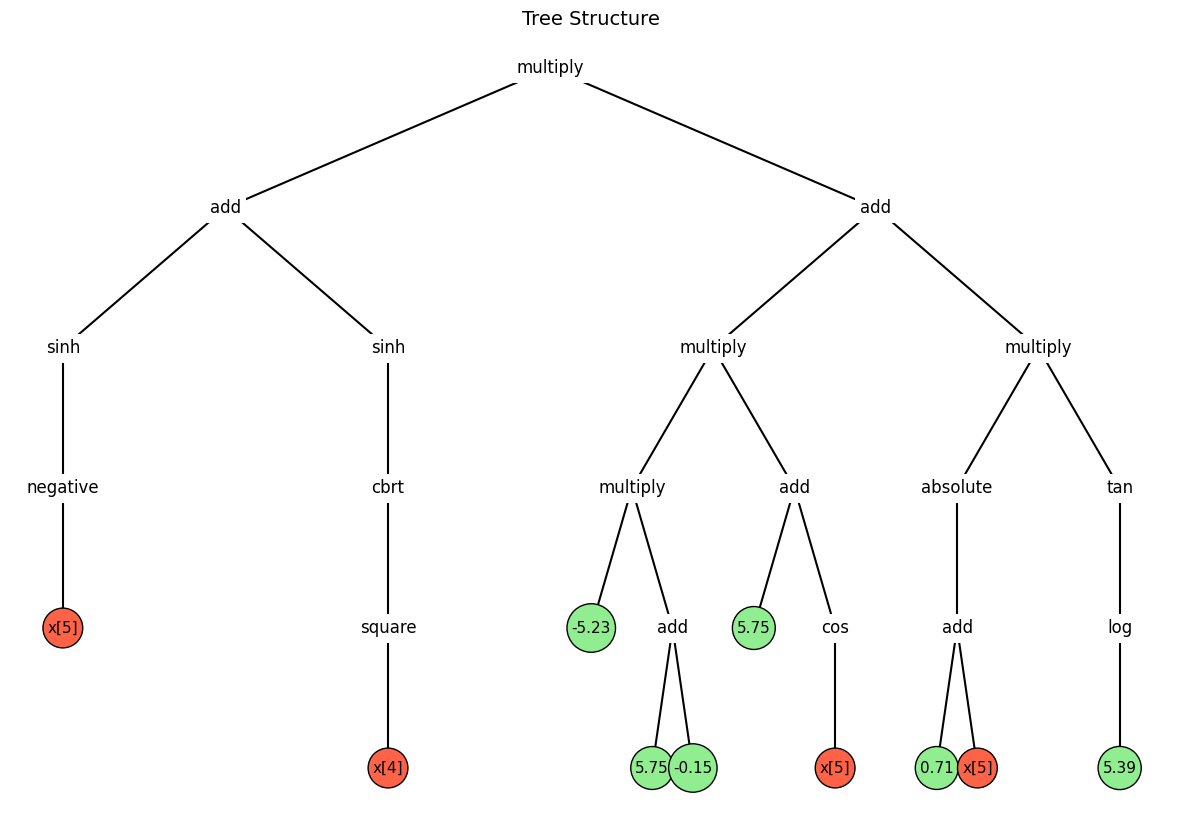

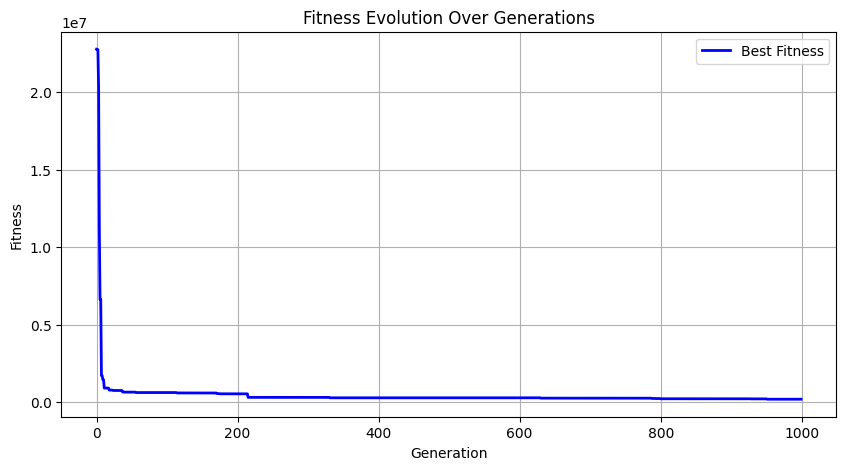

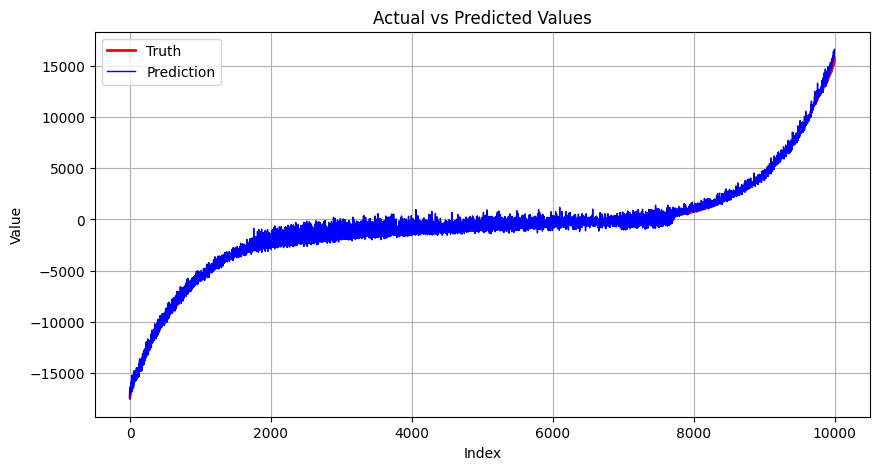

In [15]:
run_sym_reg_gp(8)